# Data Ingest and Benchmark

This notebook demonstrates GPU-accelerated telemetry loading with cuDF and Unified Virtual Memory (UVM), and benchmarks pandas vs cuDF. Inspired by [Speed Up Data Analytics on GPUs](https://developers.google.com/learn/pathways/speed-up-data-analytics-GPUs).

<a href="https://colab.research.google.com/github/KarthikSriramGit/H.E.I.M.D.A.L.L./blob/main/notebooks/01_data_ingest_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab setup: clone repo and install dependencies (run this cell first)
try:
    import google.colab
    get_ipython().system("git clone -q https://github.com/KarthikSriramGit/H.E.I.M.D.A.L.L..git")
    get_ipython().run_line_magic("cd", "H.E.I.M.D.A.L.L.")
    get_ipython().system("pip install -q pandas pyarrow numpy matplotlib")
    get_ipython().system("pip install -q cudf-cu12 2>/dev/null || true")
except Exception:
    pass

/content/H.E.I.M.D.A.L.L.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 8.9 MB/s eta 0:00:00


In [2]:
# Setup: Colab runs from repo root after clone
import sys
from pathlib import Path
ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print(f"ROOT={ROOT}")

ROOT=/content/H.E.I.M.D.A.L.L.


## Generate synthetic telemetry

In [3]:
# Generate synthetic telemetry (2M rows for meaningful cuDF benchmark)
import subprocess
parquet_path = ROOT / "data" / "synthetic" / "fleet_telemetry.parquet"
ROWS = 2_000_000
if not parquet_path.exists():
    subprocess.run([
        "python", "data/synthetic/generate_telemetry.py",
        "--rows", str(ROWS),
        "--output-dir", "data/synthetic",
        "--format", "parquet",
    ], check=True, cwd=str(ROOT))
    print(f"Generated {ROWS:,} rows")
else:
    print(f"Data exists: {parquet_path} (delete to regenerate with {ROWS:,} rows)")

Generated 2,000,000 rows


## Load with cuDF and UVM spill

The telemetry uses a **unified flat schema**: all 5 sensor types (IMU, LiDAR, CAN, GPS, Camera) share one table. Columns that don't apply to a given sensor type are `<NA>` — for example, an IMU row has no `brake_pressure_pct`, and a CAN row has no `accel_x`. This is normal for a wide Parquet table optimized for columnar access.

Below we load the full dataset, then show **per-sensor views** with only the relevant columns so the data is easy to read.

In [4]:
from src.ingest.cudf_loader import load_telemetry
from src.ingest.telemetry_schema import get_columns_for_sensor, SENSOR_TYPES

df = load_telemetry(str(parquet_path), spill=True)
backend = "cuDF" if "cudf" in str(type(df)) else "pandas"
print(f"Full dataset shape: {df.shape}  |  Backend: {backend}")
unique_types = df["sensor_type"].unique()
if hasattr(unique_types, "to_arrow"):
    unique_types = unique_types.to_arrow().to_pylist()
else:
    unique_types = unique_types.tolist()
print(f"Sensor types: {unique_types}")
print(f"\nRows per sensor type:")
counts = df["sensor_type"].value_counts()
if hasattr(counts, "to_pandas"):
    counts = counts.to_pandas()
print(counts.to_string())
print()

# Per-sensor views: only show columns relevant to each sensor (no <NA> clutter)
for stype in SENSOR_TYPES:
    cols = get_columns_for_sensor(stype)
    cols = [c for c in cols if c in df.columns]
    subset = df[df["sensor_type"] == stype][cols]
    print(f"--- {stype.upper()} ({len(subset):,} rows, {len(cols)} columns) ---")
    sample = subset.head(3)
    if hasattr(sample, "to_pandas"):
        sample = sample.to_pandas()
    print(sample.to_string(index=False))
    print()

Full dataset shape: (2000000, 33)  |  Backend: cuDF
Sensor types: ['imu', 'gps', 'lidar', 'can', 'camera']

Rows per sensor type:
sensor_type
camera    400000
imu       400000
lidar     400000
gps       400000
can       400000

--- IMU (400,000 rows, 13 columns) ---
 timestamp_ns vehicle_id sensor_type   accel_x   accel_y  accel_z    gyro_x    gyro_y    gyro_z  orientation_w  orientation_x  orientation_y  orientation_z
            0       V003         imu  0.180772  0.245564 9.980300  0.003394 -0.015557  0.015335       0.997466       0.014094      -0.003564       0.004729
            0       V008         imu  0.405369  0.441064 9.902590 -0.000811  0.004151  0.017944       0.990591      -0.008402       0.006928       0.009211
    216000540       V008         imu -0.198405 -0.010305 9.881881  0.002286 -0.018714 -0.022012       0.997044       0.001753      -0.000083       0.000752

--- LIDAR (400,000 rows, 8 columns) ---
 timestamp_ns vehicle_id sensor_type  point_count  min_range  max_ra

## Per-sensor summary statistics

Quick stats for each sensor type using only their relevant numeric columns (no NA noise).

In [5]:
for stype in SENSOR_TYPES:
    cols = get_columns_for_sensor(stype)
    cols = [c for c in cols if c in df.columns]
    subset = df[df["sensor_type"] == stype][cols]
    # Only describe numeric columns
    if hasattr(subset, "to_pandas"):
        desc = subset.to_pandas().describe()
    else:
        desc = subset.describe()
    print(f"--- {stype.upper()} summary ---")
    print(desc.to_string())
    print()

--- IMU summary ---
       timestamp_ns        accel_x        accel_y        accel_z         gyro_x        gyro_y         gyro_z  orientation_w  orientation_x  orientation_y  orientation_z
count  4.000000e+05  400000.000000  400000.000000  400000.000000  400000.000000  4.000000e+05  400000.000000  400000.000000  400000.000000  400000.000000  400000.000000
mean   4.318571e+13      -0.000312       0.001059       9.810193       0.000005  6.265601e-08       0.000022       0.994997       0.000004      -0.000005       0.000012
std    2.493852e+13       0.500177       0.499550       0.200025       0.009993  1.000873e-02       0.009981       0.002889       0.009998       0.010004       0.009979
min    0.000000e+00      -2.413561      -2.295935       8.792851      -0.046254 -5.043590e-02      -0.044266       0.990000      -0.045217      -0.052212      -0.051977
25%    2.155804e+13      -0.336078      -0.335753       9.674906      -0.006737 -6.747558e-03      -0.006703       0.992493      -0.006

## Benchmark: pandas vs cuDF

Compares load, groupby, filter, and sort on the full unified table.
- **groupby** aggregates `brake_pressure_pct` per vehicle (CAN rows; NAs from other sensors are skipped automatically).
- **filter** selects rows where `brake_pressure_pct > 90` (hard braking events).
- Time is wall-clock; memory is CPU RAM only (cuDF uses GPU VRAM, so its memory bar reflects host allocation, not GPU).

In [6]:
from src.ingest.benchmark_loader import run_benchmark, benchmark_to_dataframe

results = run_benchmark(parquet_path)
bm_df = benchmark_to_dataframe(results)
print(bm_df)

  backend operation    time_s   memory_mb
0  pandas      load  1.075028  105.538533
1  pandas   groupby  0.273481   62.776553
2  pandas    filter  0.034684   12.586592
3  pandas      sort  0.339064  534.062752
4    cudf      load  0.160630    0.236058
5    cudf   groupby  0.010516    0.032793
6    cudf    filter  0.016460    0.213379
7    cudf      sort  0.028418    0.222069


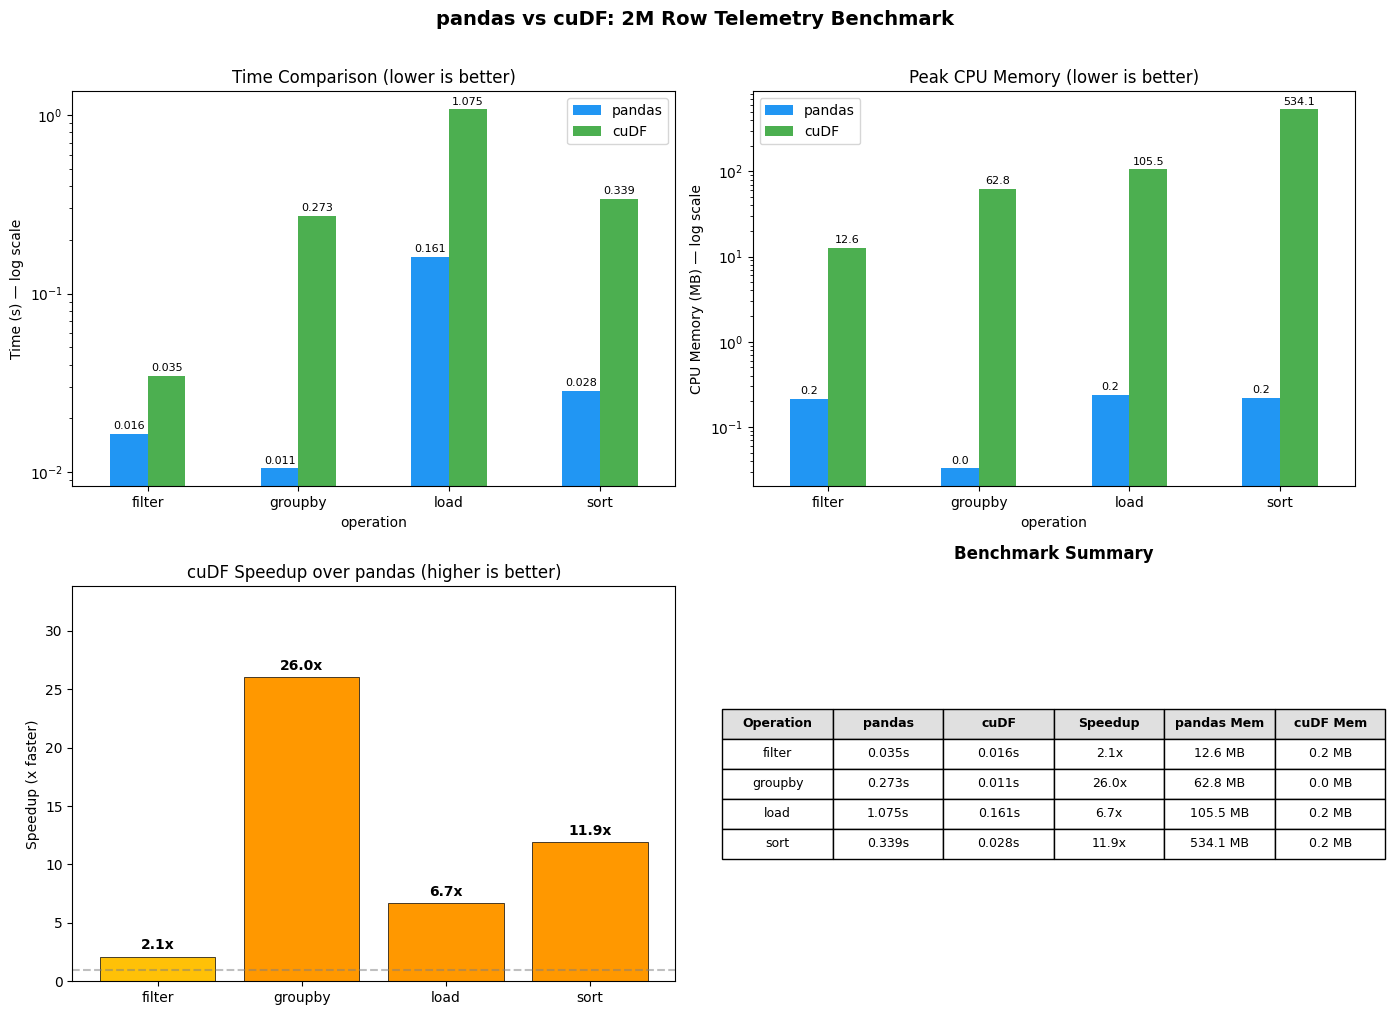

In [7]:
import matplotlib.pyplot as plt
import numpy as np

pivot_time = bm_df.pivot(index="operation", columns="backend", values="time_s")
pivot_mem = bm_df.pivot(index="operation", columns="backend", values="memory_mb")

operations = pivot_time.index.tolist()
has_cudf = "cudf" in pivot_time.columns

if has_cudf:
    time_speedup = pivot_time["pandas"] / pivot_time["cudf"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Time comparison (log scale so cuDF bars are visible)
pivot_time.plot(kind="bar", ax=axes[0, 0], rot=0, color=["#2196F3", "#4CAF50"])
axes[0, 0].set_ylabel("Time (s) — log scale")
axes[0, 0].set_yscale("log")
axes[0, 0].set_title("Time Comparison (lower is better)")
axes[0, 0].legend(["pandas", "cuDF"])
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt="%.3f", fontsize=8, padding=2)

# Top right: Memory comparison (log scale)
pivot_mem.plot(kind="bar", ax=axes[0, 1], rot=0, color=["#2196F3", "#4CAF50"])
axes[0, 1].set_ylabel("CPU Memory (MB) — log scale")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Peak CPU Memory (lower is better)")
axes[0, 1].legend(["pandas", "cuDF"])
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt="%.1f", fontsize=8, padding=2)

# Bottom left: Speedup factor bars
if has_cudf:
    colors = ["#FF9800" if s >= 5 else "#FFC107" for s in time_speedup]
    bars = axes[1, 0].bar(operations, time_speedup, color=colors, edgecolor="black", linewidth=0.5)
    axes[1, 0].set_ylabel("Speedup (x faster)")
    axes[1, 0].set_title("cuDF Speedup over pandas (higher is better)")
    axes[1, 0].axhline(y=1, color="gray", linestyle="--", alpha=0.5)
    axes[1, 0].bar_label(bars, fmt="%.1fx", fontsize=10, fontweight="bold", padding=3)
    axes[1, 0].set_ylim(bottom=0, top=float(max(time_speedup)) * 1.3)
else:
    axes[1, 0].text(0.5, 0.5, "cuDF not available", ha="center", va="center",
                     transform=axes[1, 0].transAxes, fontsize=14)
    axes[1, 0].set_title("cuDF Speedup (N/A)")

# Bottom right: Summary table
axes[1, 1].axis("off")
if has_cudf:
    table_data = []
    for op in operations:
        pd_t = pivot_time.loc[op, "pandas"]
        cu_t = pivot_time.loc[op, "cudf"]
        pd_m = pivot_mem.loc[op, "pandas"]
        cu_m = pivot_mem.loc[op, "cudf"]
        table_data.append([
            op, f"{pd_t:.3f}s", f"{cu_t:.3f}s",
            f"{pd_t / cu_t:.1f}x", f"{pd_m:.1f} MB", f"{cu_m:.1f} MB",
        ])
    table = axes[1, 1].table(
        cellText=table_data,
        colLabels=["Operation", "pandas", "cuDF", "Speedup", "pandas Mem", "cuDF Mem"],
        cellLoc="center", loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 1.6)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_facecolor("#E0E0E0")
            cell.set_text_props(fontweight="bold")
    axes[1, 1].set_title("Benchmark Summary", fontsize=12, fontweight="bold", pad=20)

fig.suptitle("pandas vs cuDF: 2M Row Telemetry Benchmark", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()